In [ ]:
import pandas as pd
import tensorflow as tf
from tensorflow.keras.utils import to_categorical
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

In [ ]:
df_train = pd.read_csv(r'training.csv')
df_test = pd.read_csv(r'test.csv')
df_valid = pd.read_csv(r'validation.csv')
df_train.head()

,text,label
0,i didnt feel humiliated,0
1,i can go from feeling so hopeless to so damned...,0
2,im grabbing a minute to post i feel greedy wrong,3
3,i am ever feeling nostalgic about the fireplac...,2
4,i am feeling grouchy,3


In [ ]:
df_train.shape

(16001, 2)

In [ ]:
X_train = np.array(df_train['text'])
X_test = np.array(df_test['text'])
X_valid = np.array(df_valid['text'])

y_train = np.array(df_train['label'])
y_test = np.array(df_test['label'])
y_valid = np.array(df_valid['label'])

In [ ]:
from nltk.stem import WordNetLemmatizer
import re
def preprocess_data(array):
  wnl = WordNetLemmatizer()
  corpus = []

  for i in range(len(array)):
    review = re.sub(r'[^a-zA-Z0-9]', ' ', array[i])
    review = review.lower().split()
    review = [wnl.lemmatize(word) for word in review]
    review = ' '.join(review)
    corpus.append(review)
  return np.array(corpus)

In [ ]:
import nltk
nltk.download('wordnet')

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [ ]:
X_train = preprocess_data(X_train)
X_test = preprocess_data(X_test)
X_valid = preprocess_data(X_valid)

In [ ]:
train_y = to_categorical(y_train, 6)
test_y = to_categorical(y_test, 6)
valid_y = to_categorical(y_valid, 6)

In [ ]:
from transformers import DistilBertTokenizerFast
tokenizer = DistilBertTokenizerFast.from_pretrained('distilbert-base-uncased')

In [ ]:
train_encodings = tokenizer(list(X_train), truncation=True, padding=True)
test_encodings = tokenizer(list(X_test), truncation=True, padding=True)
valid_encodings = tokenizer(list(X_valid), truncation=True, padding=True)

In [ ]:
import tensorflow as tf

#Convert encodings into Dataset objects
train_dataset = tf.data.Dataset.from_tensor_slices((
    dict(train_encodings),
    train_y
))

test_dataset = tf.data.Dataset.from_tensor_slices((
    dict(test_encodings),
    test_y
))

valid_dataset = tf.data.Dataset.from_tensor_slices((
    dict(valid_encodings),
    valid_y
))

In [ ]:
train_dataset

<_TensorSliceDataset element_spec=({'input_ids': TensorSpec(shape=(87,), dtype=tf.int32, name=None), 'attention_mask': TensorSpec(shape=(87,), dtype=tf.int32, name=None)}, TensorSpec(shape=(6,), dtype=tf.float32, name=None))>

In [ ]:
%pip install transformers==4.18.0

In [ ]:
from transformers import TFDistilBertForSequenceClassification, TFTrainer, TFTrainingArguments

training_args = TFTrainingArguments(
    output_dir='./results',          # output directory
    num_train_epochs = 5,
    per_device_train_batch_size=8,  # batch size per device during training
    per_device_eval_batch_size=16,   # batch size for evaluation
    warmup_steps=500,
    weight_decay=0.01,               # strength of weight decay
    logging_dir='./logs',            # directory for storing logs
    logging_steps=10,
)

In [ ]:
training_args

TFTrainingArguments(output_dir='./results', overwrite_output_dir=False, do_train=False, do_eval=False, do_predict=False, evaluation_strategy=<IntervalStrategy.NO: 'no'>, prediction_loss_only=False, per_device_train_batch_size=8, per_device_eval_batch_size=16, per_gpu_train_batch_size=None, per_gpu_eval_batch_size=None, gradient_accumulation_steps=1, eval_accumulation_steps=None, eval_delay=0, learning_rate=5e-05, weight_decay=0.01, adam_beta1=0.9, adam_beta2=0.999, adam_epsilon=1e-08, max_grad_norm=1.0, num_train_epochs=5, max_steps=-1, lr_scheduler_type=<SchedulerType.LINEAR: 'linear'>, warmup_ratio=0.0, warmup_steps=500, log_level=-1, log_level_replica=-1, log_on_each_node=True, logging_dir='./logs', logging_strategy=<IntervalStrategy.STEPS: 'steps'>, logging_first_step=False, logging_steps=10, logging_nan_inf_filter=True, save_strategy=<IntervalStrategy.STEPS: 'steps'>, save_steps=500, save_total_limit=None, save_on_each_node=False, no_cuda=False, seed=42, data_seed=None, bf16=False

In [ ]:
with training_args.strategy.scope():
    model = TFDistilBertForSequenceClassification.from_pretrained("distilbert-base-uncased", num_labels=6)

Some layers from the model checkpoint at distilbert-base-uncased were not used when initializing TFDistilBertForSequenceClassification: ['vocab_projector', 'activation_13', 'vocab_transform', 'vocab_layer_norm']
- This IS expected if you are initializing TFDistilBertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFDistilBertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some layers of TFDistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['pre_classifier', 'dropout_19', 'classifier']
You should probably TRAIN this model on a down-stream task to be able to use i

In [ ]:
model.compile(optimizer = tf.keras.optimizers.Adam(learning_rate=5e-5), loss = tf.keras.losses.CategoricalCrossentropy(from_logits=True), metrics = ['accuracy'])

In [ ]:
history = model.fit(train_dataset.batch(32), epochs=10, validation_data=valid_dataset.batch(32), verbose = 1)

Epoch 1/10
501/501 [==============================] - 186s 291ms/step - loss: 0.4441 - accuracy: 0.8418 - val_loss: 0.1690 - val_accuracy: 0.9315
Epoch 2/10
501/501 [==============================] - 143s 286ms/step - loss: 0.1399 - accuracy: 0.9403 - val_loss: 0.1599 - val_accuracy: 0.9355
Epoch 3/10
501/501 [==============================] - 144s 287ms/step - loss: 0.1044 - accuracy: 0.9512 - val_loss: 0.1548 - val_accuracy: 0.9360
Epoch 4/10
501/501 [==============================] - 144s 287ms/step - loss: 0.0871 - accuracy: 0.9608 - val_loss: 0.1818 - val_accuracy: 0.9320
Epoch 5/10
501/501 [==============================] - 144s 287ms/step - loss: 0.0763 - accuracy: 0.9658 - val_loss: 0.1901 - val_accuracy: 0.9355
Epoch 6/10
501/501 [==============================] - 143s 286ms/step - loss: 0.0557 - accuracy: 0.9773 - val_loss: 0.2523 - val_accuracy: 0.9365
Epoch 7/10
501/501 [==============================] - 144s 287ms/step - loss: 0.0467 - accuracy: 0.9817 - val_loss: 0.2264 -

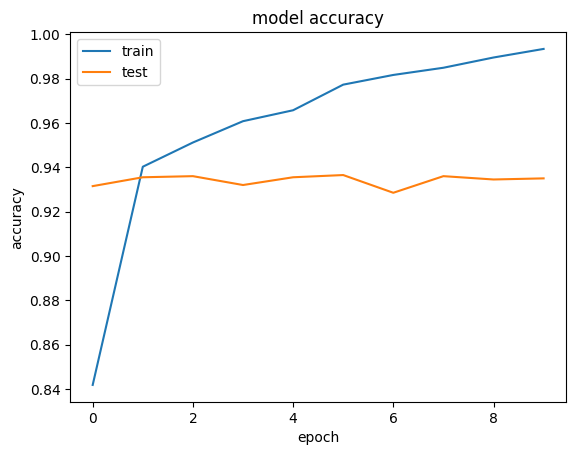

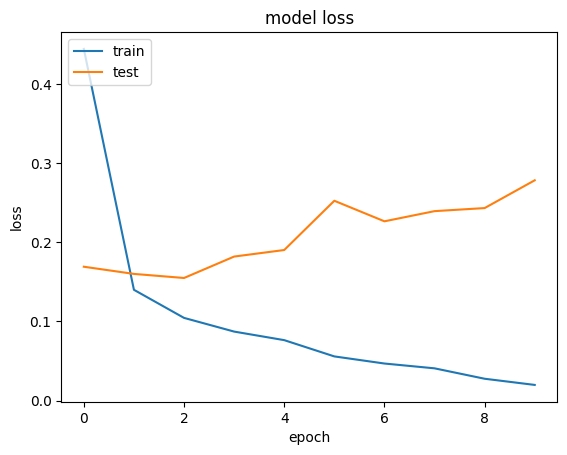

In [ ]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')

In [ ]:
model.evaluate(test_dataset.batch(32))

63/63 [==============================] - 7s 78ms/step - loss: 0.2901 - accuracy: 0.9250


[0.2901053726673126, 0.925000011920929]

In [ ]:
y_pred = model.predict(test_dataset.batch(32))

63/63 [==============================] - 7s 75ms/step


In [ ]:
y_pred[0]

array([[ 6.2994366 , -1.7273923 , -0.15550683, -0.45336935, -4.158374  ,
        -3.2608452 ],
       [ 8.196181  , -2.7569313 , -1.3718774 , -0.8521752 , -3.2459207 ,
        -3.4899282 ],
       [ 7.994334  , -2.755833  , -1.6224751 ,  0.13282633, -3.232103  ,
        -3.7849684 ],
       ...,
       [-3.3194406 ,  8.269192  , -1.1909003 , -4.4505706 , -3.8157866 ,
        -2.3273506 ],
       [-3.7351396 ,  8.220034  , -1.1180918 , -4.451851  , -3.219394  ,
        -2.484611  ],
       [-2.889979  , -3.096264  , -3.9855895 , -3.7082586 ,  4.287173  ,
         3.5049975 ]], dtype=float32)

In [ ]:
y_pred = np.argmax(y_pred[0], axis = -1)

In [ ]:
y_pred.shape

(2000,)

In [ ]:
y_test.shape

(2000,)

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix

cm = confusion_matrix(y_test, y_pred)

In [ ]:
df_test.label.value_counts()

label
1    695
0    581
3    275
4    224
2    159
5     66
Name: count, dtype: int64

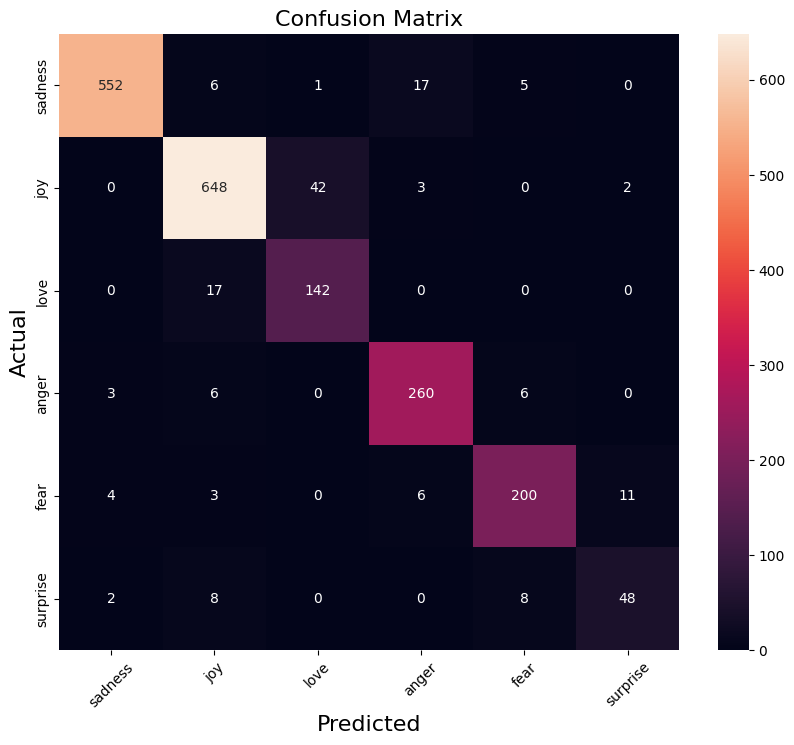

In [ ]:
class_names = ['sadness', 'joy', 'love', 'anger', 'fear', 'surprise']
cm = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted', fontsize=16)
plt.ylabel('Actual', fontsize=16)
plt.title('Confusion Matrix', fontsize=16)
plt.xticks(rotation=45)
plt.show()

In [ ]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.98      0.95      0.97       581
           1       0.94      0.93      0.94       695
           2       0.77      0.89      0.83       159
           3       0.91      0.95      0.93       275
           4       0.91      0.89      0.90       224
           5       0.79      0.73      0.76        66

    accuracy                           0.93      2000
   macro avg       0.88      0.89      0.89      2000
weighted avg       0.93      0.93      0.93      2000



Convert Tensorflow model to tflite model

In [ ]:
converter = tf.lite.TFLiteConverter.from_keras_model(model)
converter._experimental_lower_tensor_list_ops = False
converter.optimizations = [tf.lite.Optimize.DEFAULT]
converter.target_spec.supported_ops = [tf.lite.OpsSet.TFLITE_BUILTINS, tf.lite.OpsSet.SELECT_TF_OPS]
converter.inference_input_type = tf.float32
converter.inference_output_type = tf.float32
tflite_model = converter.convert()

In [ ]:
len(tflite_model)

66929544

In [ ]:
with open('model.tflite', 'wb') as f:
    f.write(tflite_model)

In [ ]:
model.summary()

Model: "tf_distil_bert_for_sequence_classification"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 distilbert (TFDistilBertMa  multiple                  66362880  
 inLayer)                                                        
                                                                 
 pre_classifier (Dense)      multiple                  590592    
                                                                 
 classifier (Dense)          multiple                  4614      
                                                                 
 dropout_19 (Dropout)        multiple                  0         
                                                                 
Total params: 66958086 (255.42 MB)
Trainable params: 66958086 (255.42 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [ ]:
model.save_pretrained('model')
tokenizer.save_pretrained('model')

('model/tokenizer_config.json',
 'model/special_tokens_map.json',
 'model/vocab.txt',
 'model/added_tokens.json',
 'model/tokenizer.json')

In [ ]:
new_model = TFDistilBertForSequenceClassification.from_pretrained('model')

Some layers from the model checkpoint at model were not used when initializing TFDistilBertForSequenceClassification: ['dropout_19']
- This IS expected if you are initializing TFDistilBertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFDistilBertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some layers of TFDistilBertForSequenceClassification were not initialized from the model checkpoint at model and are newly initialized: ['dropout_39']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
new_model.compile(optimizer = tf.keras.optimizers.Adam(learning_rate=5e-5), loss = tf.keras.losses.CategoricalCrossentropy(from_logits=True), metrics = ['accuracy'])

In [ ]:
new_model.evaluate(test_dataset.batch(32))

63/63 [==============================] - 8s 77ms/step - loss: 0.2901 - accuracy: 0.9250


[0.2901053726673126, 0.925000011920929]